In [1]:
import sys
sys.path.append('../experimental')

# Figure 5 : Temporal generalization
Due to matrices representations, np.triu is actually the lower triangle while np.tril is the upper triangle.

# Params

In [2]:
%run -n boillerplate.ipynb

# Temporal transposition on all Bthetas

In [3]:
try :
    kf_all_autotransfers = np.load('./data/fig_5_kf_autotransfers.npy', allow_pickle = True)
    
except:    
    kf_all_autotransfers = []
    for ibt, bt in enumerate(B_thetas) :
        # Data
        data, labels, le = par_load_temporal_data(timesteps = timesteps, target_btheta = bt,
                                                target_theta = None, data_type = 'one_bt',
                                                cluster_list = cluster_list)

        kf_accs = np.zeros((data.shape[0], data.shape[0], n_splits))

        # Classifying
        logreg = LogisticRegression(**opts_LR)

        kf = KFold(n_splits = n_splits)
        for ibin_train in tqdm(range(data.shape[0]), desc = 'Training and testing') :
            for i_kf, (train_index, test_index) in enumerate(kf.split(data[ibin_train,:,:])) :
                xtrain, ytrain = data[ibin_train,train_index,:], labels[train_index] #is train on axis 1 or 2
                logreg.fit(xtrain, ytrain)
                for ibin_test in range(data.shape[0]):
                    xtest, ytest = data[ibin_test,test_index,:], labels[test_index]

                    cm = metrics.confusion_matrix(ytest, logreg.predict(xtest), normalize = 'all')
                    cm *= len(le.classes_)

                    kf_accs[ibin_train, ibin_test, i_kf] = metrics.balanced_accuracy_score(ytest, logreg.predict(xtest))
                    
        kf_all_autotransfers.append(kf_accs)

    kf_all_autotransfers = np.asarray(kf_all_autotransfers)
    np.save('./data/fig_5_kf_autotransfers.npy', kf_all_autotransfers)
    


Training and testing: 100%|██████████| 61/61 [02:04<00:00,  2.03s/it]


In [4]:
    
try:
    pvals_automaps = np.load('./data/fig_5_pvals_automaps.npy')

except:
    pvals_automaps = []
    for i in range(len(B_thetas)) :
        arr = kf_all_autotransfers[::-1][i]
        
        mat = np.zeros((arr.shape[0], arr.shape[0]), dtype = list)
        for x in range(arr.shape[0]) :
            for y in range(arr.shape[0]) :
                mat[x,y] = list(arr[x,y])
        arr = mat
            
        triu = np.triu(arr)
        itriu = np.triu_indices(arr.shape[-1])
        tril = np.tril(arr).T

        triu = triu[triu!=0]
        tril = tril[tril!=0]

        pval_map = np.zeros((arr.shape[-1], arr.shape[-1]))
        for i0, el in tqdm(enumerate(triu), total = len(triu)) :
            p = permutation_test(triu[i0], tril[i0], num_rounds = num_rounds)
            pval_map[itriu[0][i0], itriu[1][i0]] = p

        pvals_automaps.append(pval_map)
        
    pvals_automaps = np.asarray(pvals_automaps)
    np.save('./data/fig_5_pvals_automaps.npy', pvals_automaps)


100%|██████████| 1891/1891 [00:49<00:00, 38.18it/s]


In [5]:
xticks = np.linspace(0, len(timesteps)-1, 7, dtype = np.int16, endpoint = True)
xticklabs = np.round(timesteps[xticks]+win_size, 2)

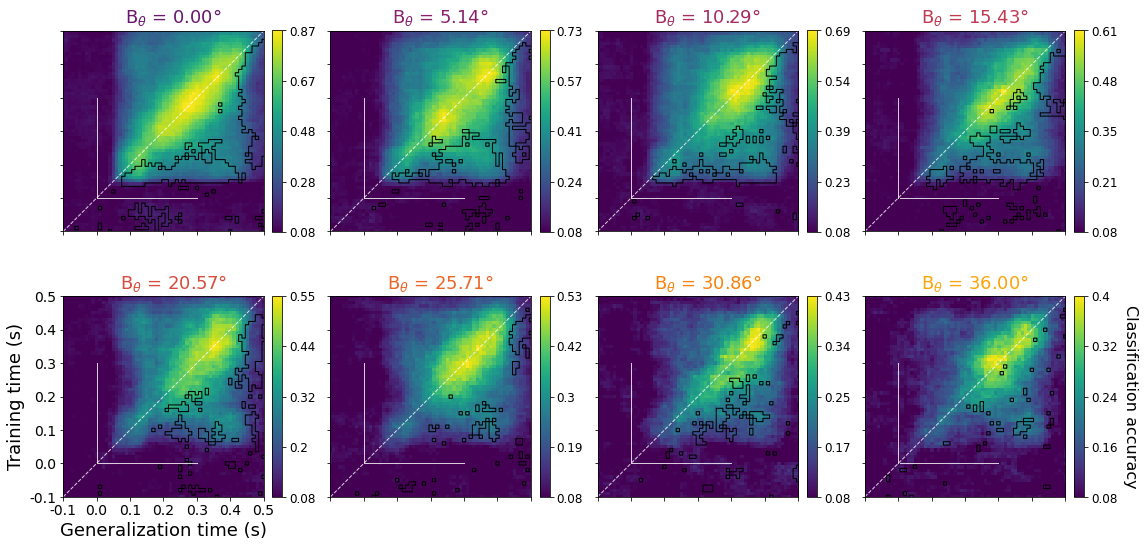

In [6]:
fig, axs = plt.subplots(nrows = 2, 
                        ncols = 4,
                        figsize = (16,8))

xticks = np.linspace(0, len(timesteps)-1, 7, dtype = np.int16, endpoint = True)
xticklabs = np.round(timesteps[xticks]+win_size, 2)
colors = plt.cm.inferno(np.linspace(.8, .3, len(B_thetas))) #tc colormap

for i, ax in enumerate(fig.axes) :
    test = kf_all_autotransfers[::-1][i].copy()
    
    # Averaging across Kfolds
    mat = np.zeros((test.shape[0], test.shape[0]))
    for x in range(test.shape[0]) :
        for y in range(test.shape[0]) :
            mat[x,y] = np.mean(test[x,y])
            
    im = ax.imshow(mat, origin = 'lower', interpolation = 'None', vmin = 1/12)
    
    # Diagonal plotting
    ax.plot([0,60],[0,60], c = 'w', linestyle = '--', alpha = .8, linewidth = 1) 
    ax.plot([10,10],[40,10], c = 'w', linestyle = '-', alpha = .8, linewidth = 1) 
    ax.plot([10.4,40],[10,10], c = 'w', linestyle = '-', alpha = .8, linewidth = 1)
    
    # Pvals
    itril = np.tril_indices(61)
    pvals = pvals_automaps[i] < 0.05
    for i1, _ in enumerate(range(len(itril[0]))) :
        pvals[itril[0][i1], itril[1][i1]] = False
    # hide FPs, for plot sake, careful not to count them later on
    #pvals[0:15,:] = False
    #pvals[:,0:15] = False

    pval_edges(pvals.T , ax = ax, lw = 1, c = 'k')
    ax.set_xlim(0,60)
    ax.set_ylim(0, 60)
    
    xtick_idxs = [int(x) for x in ax.get_xticks() if x >=0][:-1]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabs)
    ax.set_yticks(xticks)
    ax.set_yticklabels(xticklabs)
    
    if i != 4 :
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        
    if i == 4 :
        ax.set_ylabel('Training time (s)', fontsize = 18)
        ax.set_xlabel('Generalization time (s)', fontsize = 18)
        ax.tick_params(axis='both', which='major', labelsize=14)
 
    ax.set_title(r'B$_\theta$ = %.2f°' % (B_thetas[::-1][i] * 180/np.pi),
                color = colors[::-1][i], fontsize = 18, x = .55, y = 1.01)
    cbar = fig.colorbar(im, ax = ax,fraction=0.046, pad=0.04)
    cbar.set_ticks(np.linspace(1/12, np.max(mat), 5))
    cbar.set_ticklabels(np.round(np.linspace(1/12, np.max(mat), 5), 2))
    cbar.ax.tick_params(labelsize = 12)
    
    if i == 7 :
        cbar.ax.set_ylabel('Classification accuracy', rotation = 270, labelpad = 20,
                      fontsize = 16)

    
fig.tight_layout()
fig.savefig('./output/sup_8_tempo_gen.pdf', bbox_inches='tight', dpi=200, transparent=True)
plt.show()

# Plotting only the halves of matrices

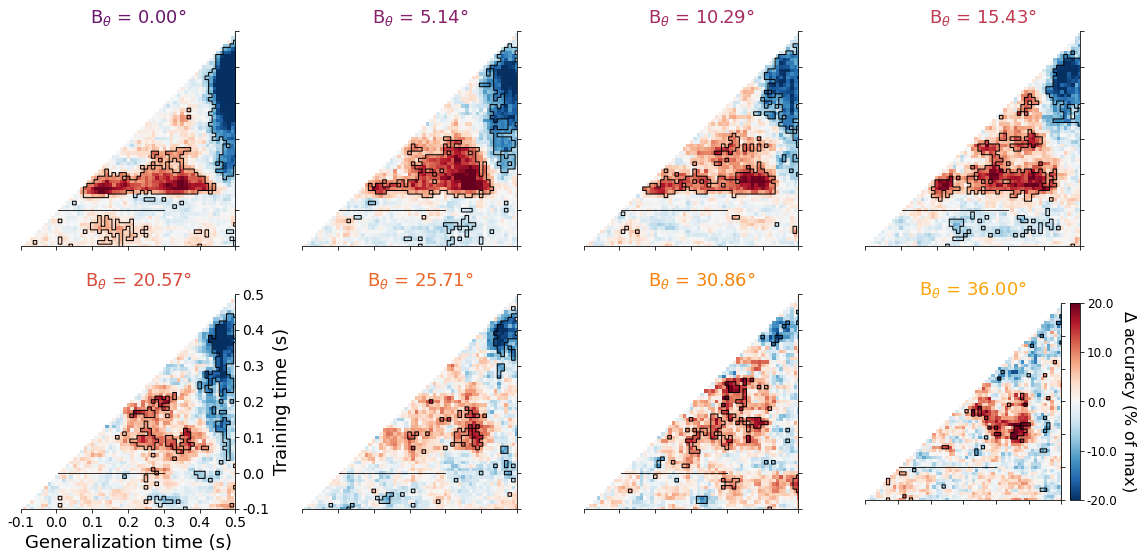

In [7]:
fig, axs = plt.subplots(nrows = 2, 
                        ncols = 4,
                        figsize = (16,8))

xticks = np.linspace(0, len(timesteps)-1, 7, dtype = np.int16, endpoint = True)
xticklabs = np.round(timesteps[xticks]+win_size, 2)
colors = plt.cm.inferno(np.linspace(.8, .3, len(B_thetas))) #tc colormap

for i, ax in enumerate(fig.axes) :
    test = kf_all_autotransfers[::-1][i].copy()
    
    # Averaging across Kfolds
    mat = np.zeros((test.shape[0], test.shape[0]))
    for x in range(test.shape[0]) :
        for y in range(test.shape[0]) :
            mat[x,y] = np.mean(test[x,y])
       
    triu = np.triu(mat)
    itriu = np.triu_indices(mat.shape[-1])
    tril = np.tril(mat).T
    diff = (triu-tril)/np.max(mat)
    diff*=100
    tril2 = np.tril_indices(diff.shape[-1])
    diff[tril2]= None
    
    im = ax.imshow(diff, origin = 'lower', interpolation = 'None',
                   cmap = 'RdBu_r',
                  norm = mcols.TwoSlopeNorm(
                                      vmin = -20,
                                       vmax = 20,
                                          vcenter = 0))
    
    # Diagonal plotting
    #ax.plot([10,10],[40,10], c = 'w', linestyle = '-', alpha = .8, linewidth = 1) 
    ax.plot([10.4,40],[10,10], c = 'k', linestyle = '-', alpha = .8, linewidth = 1)
    
    # Pvals
    itril = np.tril_indices(61)
    pvals = pvals_automaps[i] < 0.05
    for i1, _ in enumerate(range(len(itril[0]))) :
        pvals[itril[0][i1], itril[1][i1]] = False

    pval_edges(pvals.T , ax = ax, lw = 1, c = 'k')
    ax.set_xlim(0,60)
    ax.set_ylim(0, 60)
    
    xtick_idxs = [int(x) for x in ax.get_xticks() if x >=0][:-1]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabs)
    ax.set_yticks(xticks)
    ax.set_yticklabels(xticklabs)
    
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.tick_right()
    if i != 4 :
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        
    if i == 4 :
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position('right')
        ax.set_ylabel('Training time (s)', fontsize = 18)
        ax.set_xlabel('Generalization time (s)', fontsize = 18)
        ax.tick_params(axis='both', which='major', labelsize=14)
 
    ax.set_title(r'B$_\theta$ = %.2f°' % (B_thetas[::-1][i] * 180/np.pi),
                color = colors[::-1][i], fontsize = 18, x = .55, y = 1.01)
    
    
    if i == 7 :
        cbar = fig.colorbar(im, ax = ax,fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize = 12)
        cbar.ax.set_ylabel(r'$\Delta$ accuracy (% of max)', rotation = 270, labelpad = 20,
                      fontsize = 16)
        cticks = np.concatenate((np.linspace(np.nanmin(diff), 0, 3),
                        np.linspace(0, np.nanmax(diff), 3)))
        cticks = np.delete(cticks, 2)
        cticks = np.linspace(-20, 20, 5)
        cbar.set_ticks(cticks)
        cbar.set_ticklabels(np.round(cticks, 2))

    
fig.tight_layout()
fig.savefig('./output/fig_5_tempo_gen.pdf', bbox_inches='tight', dpi=200, transparent=True)
plt.show()

Generalizing from Bt0 to Bt5.14 : 	 0.462 signif pixels
Generalizing from Bt0 to Bt10.29 : 	 0.464 signif pixels
Generalizing from Bt0 to Bt15.43 : 	 0.371 signif pixels
Generalizing from Bt0 to Bt20.57 : 	 0.364 signif pixels
Generalizing from Bt0 to Bt25.71 : 	 0.226 signif pixels
Generalizing from Bt0 to Bt30.86 : 	 0.110 signif pixels
Generalizing from Bt0 to Bt36.00 : 	 0.108 signif pixels


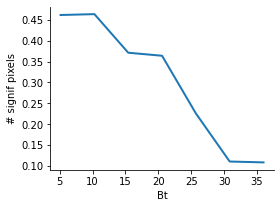

In [8]:
lstlen = []
for ibt, bt in enumerate(B_thetas[:-1][::-1]) :
    itril = np.tril_indices(61)
    pvals = pvals_automaps[ibt] < 0.05
    for i1, _ in enumerate(range(len(itril[0]))) :
        pvals[itril[0][i1], itril[1][i1]] = False
        
    # hide FPs, for plot sake, careful not to count them later on
    pvals[0:15,:] = False
    pvals[:,0:15] = False
    
    lstlen.append(len(np.where(pvals == True)[0]))
    print('Generalizing from Bt0 to Bt%.2f : \t %.3f signif pixels' % (bt*180/np.pi, len(np.where(pvals == True)[0]) / (31*31)))
    
fig, ax = plt.subplots(figsize = (4,3))
ax.plot(B_thetas[:-1][::-1]*180/np.pi, np.asarray(lstlen)/(31*31), lw = 2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('# signif pixels')
ax.set_xlabel('Bt')
plt.show()

# K-folding the time transpositions

In [9]:
try:
    kf_all_transfers_frombt0 = np.load('./data/sup_8_kf_tempo_cond_frombt0.npy', allow_pickle = True)

except:
    # Learning on Btheta = 0 and testing on higher bthetas
    data_bt0, labels_bt0, le_bt0 = par_load_temporal_data(timesteps = timesteps, target_btheta = B_thetas[-1],
                                                target_theta = None, data_type = 'one_bt',
                                                cluster_list = cluster_list)
    size_split = int(data_bt0.shape[-1]/n_splits)

    kf_all_transfers_frombt0 = []
    for ibt, bt in enumerate(B_thetas[:-1]) :
        data_target, labels_target, le_target = par_load_temporal_data(timesteps = timesteps, target_btheta = bt,
                                                    target_theta = None, data_type = 'one_bt',
                                                    cluster_list = cluster_list)
        logreg = LogisticRegression(**opts_LR)

        kf_accs = np.zeros((data_bt0.shape[0], data_bt0.shape[0]), dtype = object)
        for ibin_train in tqdm(range(data_bt0.shape[0]), desc = 'Transpo') :
            for ibin_test in range(data_bt0.shape[0]) :
                one_kf_acc = []
                for i_kf in range(n_splits) :
                    x_train = data_bt0[ibin_train,
                                       i_kf*size_split : (i_kf+1)*size_split]
                    y_train = labels_bt0[i_kf*size_split : (i_kf+1)*size_split]
                    logreg.fit(x_train, y_train)

                    x_test = np.delete(data_target[ibin_test,:,:],
                                      np.arange(i_kf*size_split,(i_kf+1)*size_split),
                                      axis = 0)
                    y_test = np.delete(labels_target,
                                      np.arange(i_kf*size_split,(i_kf+1)*size_split))

                    one_kf_acc.append(metrics.balanced_accuracy_score(y_test, logreg.predict(x_test)))

                kf_accs[ibin_train, ibin_test] = one_kf_acc
        kf_all_transfers_frombt0.append(kf_accs)

    kf_all_transfers_frombt0 = np.asarray(kf_all_transfers_frombt0)
    np.save('./data/sup_8_kf_tempo_cond_frombt0.npy', kf_all_transfers_frombt0)
    


Transpo: 100%|██████████| 61/61 [22:36<00:00, 22.23s/it]


In [10]:

try:
    kf_all_transfers_frombt36 = np.load('./data/sup_8_kf_tempo_cond_frombt36.npy', allow_pickle = True)
    
except:
    # Learning on Btheta = 36 and testing on lower bthetas
    data_bt36, labels_bt36, le_bt36 = par_load_temporal_data(timesteps = timesteps, target_btheta = B_thetas[0],
                                                    target_theta = None, data_type = 'one_bt',
                                                    cluster_list = cluster_list)
    
    size_split = int(data_bt36.shape[-1]/n_splits)

    kf_all_transfers_frombt36 = []
    for ibt, bt in enumerate(B_thetas[1:]) :
        data_target, labels_target, le_target = par_load_temporal_data(timesteps = timesteps, target_btheta = bt,
                                                    target_theta = None, data_type = 'one_bt',
                                                    cluster_list = cluster_list)
        logreg = LogisticRegression(**opts_LR)

        kf_accs = np.zeros((data_bt36.shape[0], data_bt36.shape[0]), dtype = object)
        for ibin_train in tqdm(range(data_bt36.shape[0]), desc = 'Transpo') :
            for ibin_test in range(data_bt36.shape[0]) :
                one_kf_acc = []
                for i_kf in range(n_splits) :
                    x_train = data_bt36[ibin_train,
                                       i_kf*size_split : (i_kf+1)*size_split]
                    y_train = labels_bt36[i_kf*size_split :
                                      (i_kf+1)*size_split]
                    logreg.fit(x_train, y_train)

                    x_test = np.delete(data_target[ibin_test,:,:],
                                      np.arange(i_kf*size_split,(i_kf+1)*size_split),
                                      axis = 0)
                    y_test = np.delete(labels_target,
                                      np.arange(i_kf*size_split,(i_kf+1)*size_split))

                    one_kf_acc.append(metrics.balanced_accuracy_score(y_test, logreg.predict(x_test)))

                kf_accs[ibin_train, ibin_test] = one_kf_acc
        kf_all_transfers_frombt36.append(kf_accs)

    kf_all_transfers_frombt36 = np.asarray(kf_all_transfers_frombt36)
    np.save('./data/sup_8_kf_tempo_cond_frombt36.npy', kf_all_transfers_frombt36)
    


Transpo: 100%|██████████| 61/61 [20:55<00:00, 20.57s/it]


# Computing the pvals

In [11]:
# For frombt0

try:
    pval_maps_frombt0 = np.load('./data/sup_8_pvals_frombt0.npy')
    
except:
    pval_maps_frombt0 = []
    for i in range(7) :
        arr = kf_all_transfers_frombt0[::-1][i]
        triu = np.triu(arr)
        itriu = np.triu_indices(arr.shape[-1])
        tril = np.tril(arr).T

        triu = triu[triu!=0]
        tril = tril[tril!=0]

        pval_map = np.zeros((arr.shape[-1], arr.shape[-1]))
        for i0, el in tqdm(enumerate(triu), total = len(triu)) :
            p = permutation_test(triu[i0], tril[i0], num_rounds = num_rounds)
            pval_map[itriu[0][i0], itriu[1][i0]] = p

        pval_maps_frombt0.append(pval_map)
        
    pval_maps_frombt0 = np.asarray(pval_maps_frombt0)
    np.save('./data/sup_8_pvals_frombt0.npy', pval_maps_frombt0)
    


100%|██████████| 1891/1891 [00:55<00:00, 33.81it/s]


In [12]:
# For frombt36
try:
    pval_maps_frombt36 = np.load('./data/sup_8_pvals_frombt36.npy')
    
except:
    pval_maps_frombt36 = []
    for i in range(7) :
        arr = kf_all_transfers_frombt36[::-1][i] # /!\ we need to reswap the orders after
        triu = np.triu(arr)
        itriu = np.triu_indices(arr.shape[-1])
        tril = np.tril(arr).T

        triu = triu[triu!=0]
        tril = tril[tril!=0]

        pval_map = np.zeros((arr.shape[-1], arr.shape[-1]))
        for i0, el in tqdm(enumerate(triu), total = len(triu)) :
            p = permutation_test(triu[i0], tril[i0], num_rounds = num_rounds)
            pval_map[itriu[0][i0], itriu[1][i0]] = p

        pval_maps_frombt36.append(pval_map)
        
    pval_maps_frombt36 = np.asarray(pval_maps_frombt36)
    np.save('./data/sup_8_pvals_frombt36.npy', pval_maps_frombt36)
    


100%|██████████| 1891/1891 [00:47<00:00, 40.23it/s]


# Showing condition transposing with the kfolded transfer

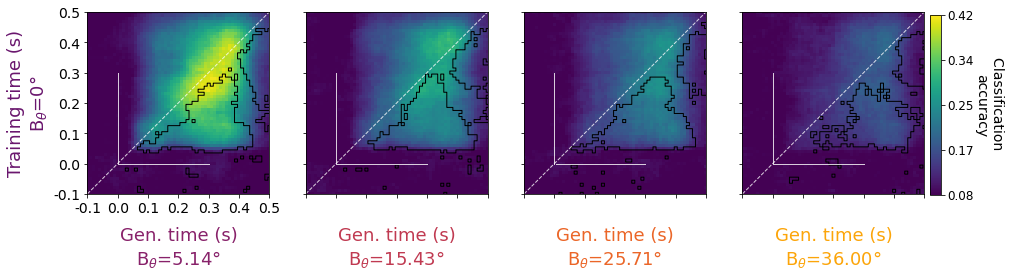

In [13]:
# Experimental, from bt0
fig, axs = plt.subplots(figsize = (15,5), ncols = 4)

colors = plt.cm.inferno(np.linspace(.8, .3, len(B_thetas))) #tc colormap

show_idxs = [0,2,4,6]
arr = kf_all_transfers_frombt0[::-1]

for i0, ibt in enumerate(show_idxs) :
    bt = B_thetas[:-1][::-1][ibt]
    
    # Averaging across Kfolds
    mat = np.zeros((arr[ibt].shape[0],arr[ibt].shape[0]))
    for x in range(arr[ibt].shape[0]) :
        for y in range(arr[ibt].shape[0]) :
            mat[x,y] = np.mean(arr[ibt][x,y])
    #print(np.min(mat), np.max(mat))
            
    # Imshow
    im = axs[i0].imshow(mat, origin = 'lower', interpolation = 'None',
                       vmin = 1/12, vmax = .42, zorder = 0)
    
    # Diagonal plotting
    axs[i0].plot([0,60],[0,60], c = 'w', linestyle = '--', alpha = .8, linewidth = 1) 
    axs[i0].plot([10,10],[40,10], c = 'w', linestyle = '-', alpha = .8, linewidth = 1) 
    axs[i0].plot([10.4,40],[10,10], c = 'w', linestyle = '-', alpha = .8, linewidth = 1)
    
    # Pvals
    itril = np.tril_indices(61)
    pvals = pval_maps_frombt0[ibt] < 0.05
    for i1, _ in enumerate(range(len(itril[0]))) :
        pvals[itril[0][i1], itril[1][i1]] = False
    # hide FPs, for plot sake, careful not to count them later on
    #pvals[0:15,:] = False
    #pvals[:,0:15] = False
    pval_edges(pvals.T , ax = axs[i0], lw = 1)
    axs[i0].set_xlim(0,60)
    axs[i0].set_ylim(0, 60)
    
    # Axis parameters
    axs[i0].set_xticks(xticks)
    axs[i0].set_yticks(xticks)
    
    if i0 > 0 : 
        axs[i0].set_xticklabels([])
        axs[i0].set_yticklabels([])
    else :
        axs[i0].set_xticklabels(xticklabs)
        axs[i0].set_yticklabels(xticklabs)
        
    # Label parameters
    if i0 == 0 :
        axs[i0].set_ylabel('Training time (s)\n' + r'B$_\theta$=0°', 
                      color = colors[-1],
                      fontsize = 18)
        axs[i0].tick_params(axis='both', which='major', labelsize=14)
        
    axs[i0].set_xlabel('Gen. time (s)\n' + r'B$_\theta$=%.2f°' % (bt*180/np.pi),
                  color = colors[::-1][ibt+1],
                  fontsize = 18)
    axs[i0].xaxis.set_label_coords(.5, -0.18)
    
    # Colorbar 
    if i0 == 3 :
        cax = fig.add_axes([axs[i0].get_position().x1+0.005, # offset from the right of the axis
                            axs[i0].get_position().y0+-.002, #bottom of the colorbar
                            0.01, #width of the colorbar
                            .5]) #height of the colorbar
        cb = fig.colorbar(im, cax = cax, ticks = np.linspace(1/12, .42, 5))
        cax.set_ylabel('Classification \naccuracy', rotation = 270, labelpad = 30,
                      fontsize = 14)
        cb.ax.tick_params(labelsize = 12)
        cb.ax.set_yticklabels(np.round(np.linspace(1/12, .42, 5),
                                      2))
        
fig.savefig('./output/sup_8_tempo_gen_frombt0.pdf', bbox_inches='tight', dpi=200, transparent=True)
plt.show()

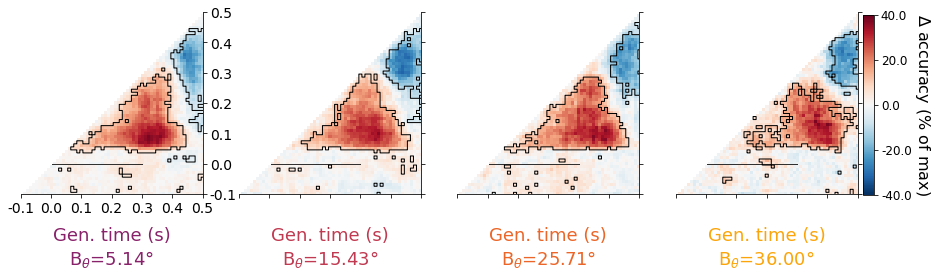

In [14]:
# Experimental, from bt0
fig, axs = plt.subplots(figsize = (15,5), ncols = 4)

colors = plt.cm.inferno(np.linspace(.8, .3, len(B_thetas))) #tc colormap

show_idxs = [0,2,4,6]
arr = kf_all_transfers_frombt0[::-1]

for i0, ibt in enumerate(show_idxs) :
    bt = B_thetas[:-1][::-1][ibt]
    
    # Averaging across Kfolds
    mat = np.zeros((arr[ibt].shape[0],arr[ibt].shape[0]))
    for x in range(arr[ibt].shape[0]) :
        for y in range(arr[ibt].shape[0]) :
            mat[x,y] = np.mean(arr[ibt][x,y])
    #print(np.min(mat), np.max(mat))
          
    triu = np.triu(mat)
    itriu = np.triu_indices(mat.shape[-1])
    tril = np.tril(mat).T
    diff = (triu-tril)/np.max(mat)
    diff*=100
    tril2 = np.tril_indices(diff.shape[-1])
    diff[tril2]= None
    
    # Imshow
    im = axs[i0].imshow(diff, origin = 'lower', interpolation = 'None',
                   cmap = 'RdBu_r',
                  norm = mcols.TwoSlopeNorm(
                                      vmin = -40,
                                       vmax = 40,
                                          vcenter = 0))
    
    # Diagonal plotting
    axs[i0].plot([10.4,40],[10,10], c = 'k', linestyle = '-', alpha = .8, linewidth = 1)
    
    # Pvals
    itril = np.tril_indices(61)
    pvals = pval_maps_frombt0[ibt] < 0.05
    for i1, _ in enumerate(range(len(itril[0]))) :
        pvals[itril[0][i1], itril[1][i1]] = False
    # hide FPs, for plot sake, careful not to count them later on
    #pvals[0:15,:] = False
    #pvals[:,0:15] = False
    pval_edges(pvals.T , ax = axs[i0], lw = 1)
    axs[i0].set_xlim(0,60)
    axs[i0].set_ylim(0, 60)
    
    # Axis parameters
    axs[i0].set_xticks(xticks)
    axs[i0].set_yticks(xticks)
    
    axs[i0].spines['left'].set_visible(False)
    axs[i0].spines['top'].set_visible(False)
    axs[i0].yaxis.tick_right()
    
    if i0 > 0 : 
        axs[i0].set_xticklabels([])
        axs[i0].set_yticklabels([])
    else :
        axs[i0].yaxis.tick_right()
        axs[i0].yaxis.set_label_position('right')
        axs[i0].set_xticklabels(xticklabs)
        axs[i0].set_yticklabels(xticklabs)
        
    # Label parameters
    if i0 == 0 :
        axs[i0].set_ylabel('Training time (s)\n' + r'B$_\theta$=0°', 
                      color = colors[-1],
                      fontsize = 18)
        axs[i0].tick_params(axis='both', which='major', labelsize=14)
        
    axs[i0].set_xlabel('Gen. time (s)\n' + r'B$_\theta$=%.2f°' % (bt*180/np.pi),
                  color = colors[::-1][ibt+1],
                  fontsize = 18)
    axs[i0].xaxis.set_label_coords(.5, -0.18)
    
    # Colorbar 
    if i0 == 3 :
        cax = fig.add_axes([axs[i0].get_position().x1+0.005, # offset from the right of the axis
                            axs[i0].get_position().y0+-.002, #bottom of the colorbar
                            0.01, #width of the colorbar
                            .5]) #height of the colorbar
        cb = fig.colorbar(im, cax = cax)
        cb.ax.set_ylabel(r'$\Delta$ accuracy (% of max)', rotation = 270, labelpad = 20,
              fontsize = 16)
        cb.ax.tick_params(labelsize = 12)
        cticks = np.linspace(-40, 40, 5)
        cb.set_ticks(cticks)
        cb.set_ticklabels(np.round(cticks, 2))

fig.savefig('./output/fig_5_frombt0.pdf', bbox_inches='tight', dpi=200, transparent=True)
plt.show()

Generalizing from Bt0 to Bt5.14 : 	 0.677 signif pixels
Generalizing from Bt0 to Bt10.29 : 	 0.655 signif pixels
Generalizing from Bt0 to Bt15.43 : 	 0.669 signif pixels
Generalizing from Bt0 to Bt20.57 : 	 0.708 signif pixels
Generalizing from Bt0 to Bt25.71 : 	 0.665 signif pixels
Generalizing from Bt0 to Bt30.86 : 	 0.621 signif pixels
Generalizing from Bt0 to Bt36.00 : 	 0.555 signif pixels


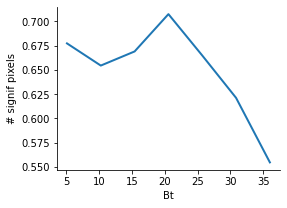

In [15]:
lstlen = []
for ibt, bt in enumerate(B_thetas[:-1][::-1]) :
    itril = np.tril_indices(61)
    pvals = pval_maps_frombt0[ibt] < 0.05
    for i1, _ in enumerate(range(len(itril[0]))) :
        pvals[itril[0][i1], itril[1][i1]] = False
        
    # hide FPs, for plot sake, careful not to count them later on
    pvals[0:15,:] = False
    pvals[:,0:15] = False
    
    lstlen.append(len(np.where(pvals == True)[0]))
    print('Generalizing from Bt0 to Bt%.2f : \t %.3f signif pixels' % (bt*180/np.pi, len(np.where(pvals == True)[0]) / (31*31)))
    
fig, ax = plt.subplots(figsize = (4,3))
ax.plot(B_thetas[:-1][::-1]*180/np.pi, np.asarray(lstlen)/(31*31), lw = 2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('# signif pixels')
ax.set_xlabel('Bt')
plt.show()

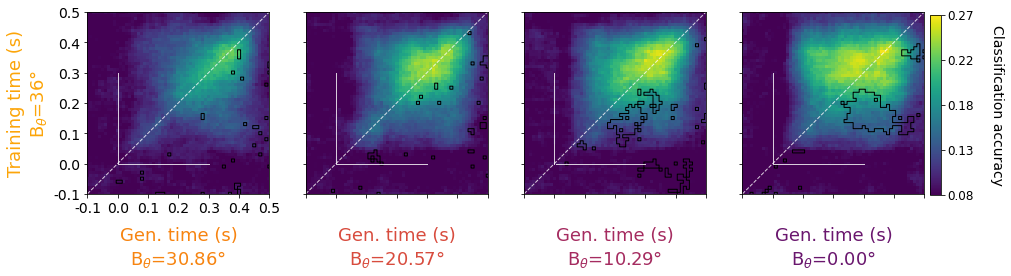

In [16]:
# Experimental, from bt36
fig, axs = plt.subplots(figsize = (15,5), ncols = 4)

colors = plt.cm.inferno(np.linspace(.8, .3, len(B_thetas))) #tc colormap

show_idxs = [0,2,4,6]
arr = kf_all_transfers_frombt36

for i0, ibt in enumerate(show_idxs) :
    bt = B_thetas[1:][ibt]
    
    # Averaging across Kfolds
    mat = np.zeros((arr[ibt].shape[0],arr[ibt].shape[0]))
    for x in range(arr[ibt].shape[0]) :
        for y in range(arr[ibt].shape[0]) :
            mat[x,y] = np.mean(arr[ibt][x,y])
    #print(np.min(mat), np.max(mat))
    
    # Imshow
    im = axs[i0].imshow(mat, origin = 'lower', interpolation = 'None',
                       vmin = 1/12, vmax = .27)
    
    # Diagonal plotting
    axs[i0].plot([0,60],[0,60], c = 'w', linestyle = '--', alpha = .8, linewidth = 1) 
    axs[i0].plot([10,10],[40,10], c = 'w', linestyle = '-', alpha = .8, linewidth = 1) 
    axs[i0].plot([10.4,40],[10,10], c = 'w', linestyle = '-', alpha = .8, linewidth = 1)
    
    
    # Pvals
    itril = np.tril_indices(61)
    pvals = pval_maps_frombt36[::-1][ibt] < 0.05
    for i1, _ in enumerate(range(len(itril[0]))) :
        pvals[itril[0][i1], itril[1][i1]] = False
    # hide FPs, for plot sake, careful not to count them later on
    #pvals[0:15,:] = False
    #pvals[:,0:15] = False
    pval_edges(pvals.T , ax = axs[i0], lw = 1)
    axs[i0].set_xlim(0,60)
    axs[i0].set_ylim(0, 60)
    
    
    # Axis parameters
    axs[i0].set_xticks(xticks)
    axs[i0].set_yticks(xticks)
    
    if i0 > 0 : 
        axs[i0].set_xticklabels([])
        axs[i0].set_yticklabels([])
    else :
        axs[i0].set_xticklabels(xticklabs)
        axs[i0].set_yticklabels(xticklabs)
        
    # Label parameters
    if i0 == 0 :
        axs[i0].set_ylabel('Training time (s)\n' + r'B$_\theta$=36°', 
                      color = colors[0],
                      fontsize = 18)
        axs[i0].tick_params(axis='both', which='major', labelsize=14)
        
    axs[i0].set_xlabel('Gen. time (s)\n' + r'B$_\theta$=%.2f°' % (bt*180/np.pi),
                  color = colors[ibt+1],
                  fontsize = 18)
    axs[i0].xaxis.set_label_coords(.5, -0.18)
    
    # Colorbar 
    if i0 == 3 :
        cax = fig.add_axes([axs[i0].get_position().x1+0.005, # offset from the right of the axis
                            axs[i0].get_position().y0+-.002, #bottom of the colorbar
                            0.01, #width of the colorbar
                            .5]) #height of the colorbar
        cb = fig.colorbar(im, cax = cax, ticks = np.linspace(1/12, .27, 5))
        cax.set_ylabel('Classification accuracy', rotation = 270, labelpad = 30,
                      fontsize = 14)
        cb.ax.tick_params(labelsize = 12)
        cb.ax.set_yticklabels(np.round(np.linspace(1/12, .27, 5),
                                      2))
        
fig.savefig('./output/sup_8_tempo_gen_frombt36.pdf', bbox_inches='tight', dpi=200, transparent=True)
plt.show()

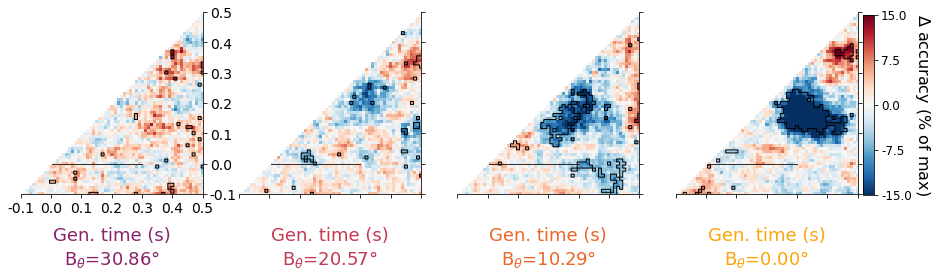

In [17]:
# Experimental, from bt0
fig, axs = plt.subplots(figsize = (15,5), ncols = 4)

colors = plt.cm.inferno(np.linspace(.8, .3, len(B_thetas))) #tc colormap

show_idxs = [0,2,4,6]
arr = kf_all_transfers_frombt36

for i0, ibt in enumerate(show_idxs) :
    bt = B_thetas[1:][ibt]
    
    # Averaging across Kfolds
    mat = np.zeros((arr[ibt].shape[0],arr[ibt].shape[0]))
    for x in range(arr[ibt].shape[0]) :
        for y in range(arr[ibt].shape[0]) :
            mat[x,y] = np.mean(arr[ibt][x,y])
    #print(np.min(mat), np.max(mat))
          
    triu = np.triu(mat)
    itriu = np.triu_indices(mat.shape[-1])
    tril = np.tril(mat).T
    diff = (triu-tril)/np.max(mat)
    diff*=100
    tril2 = np.tril_indices(diff.shape[-1])
    diff[tril2]= None
    
    # Imshow
    im = axs[i0].imshow(diff, origin = 'lower', interpolation = 'None',
                   cmap = 'RdBu_r',
                  norm = mcols.TwoSlopeNorm(
                                      vmin = -15,
                                       vmax = 15,
                                          vcenter = 0))
    
    # Diagonal plotting
    axs[i0].plot([10.4,40],[10,10], c = 'k', linestyle = '-', alpha = .8, linewidth = 1)
    
    # Pvals
    itril = np.tril_indices(61)
    pvals = pval_maps_frombt36[::-1][ibt] < 0.05
    for i1, _ in enumerate(range(len(itril[0]))) :
        pvals[itril[0][i1], itril[1][i1]] = False
    # hide FPs, for plot sake, careful not to count them later on
    #pvals[0:15,:] = False
    #pvals[:,0:15] = False
    pval_edges(pvals.T , ax = axs[i0], lw = 1)
    axs[i0].set_xlim(0,60)
    axs[i0].set_ylim(0, 60)
    
    # Axis parameters
    axs[i0].set_xticks(xticks)
    axs[i0].set_yticks(xticks)
    
    axs[i0].spines['left'].set_visible(False)
    axs[i0].spines['top'].set_visible(False)
    axs[i0].yaxis.tick_right()
    
    if i0 > 0 : 
        axs[i0].set_xticklabels([])
        axs[i0].set_yticklabels([])
    else :
        axs[i0].yaxis.tick_right()
        axs[i0].yaxis.set_label_position('right')
        axs[i0].set_xticklabels(xticklabs)
        axs[i0].set_yticklabels(xticklabs)
        
    # Label parameters
    if i0 == 0 :
        axs[i0].set_ylabel('Training time (s)\n' + r'B$_\theta$=0°', 
                      color = colors[-1],
                      fontsize = 18)
        axs[i0].tick_params(axis='both', which='major', labelsize=14)
        
    axs[i0].set_xlabel('Gen. time (s)\n' + r'B$_\theta$=%.2f°' % (bt*180/np.pi),
                  color = colors[::-1][ibt+1],
                  fontsize = 18)
    axs[i0].xaxis.set_label_coords(.5, -0.18)
    
    # Colorbar 
    if i0 == 3 :
        cax = fig.add_axes([axs[i0].get_position().x1+0.005, # offset from the right of the axis
                            axs[i0].get_position().y0+-.002, #bottom of the colorbar
                            0.01, #width of the colorbar
                            .5]) #height of the colorbar
        cb = fig.colorbar(im, cax = cax)
        cb.ax.set_ylabel(r'$\Delta$ accuracy (% of max)', rotation = 270, labelpad = 20,
              fontsize = 16)
        cb.ax.tick_params(labelsize = 12)
        cticks = np.linspace(-15, 15, 5)
        cb.set_ticks(cticks)
        cb.set_ticklabels(np.round(cticks, 2))

fig.savefig('./output/fig_5_frombt36.pdf', bbox_inches='tight', dpi=200, transparent=True)
plt.show()

Generalizing from Bt36 to Bt30.86 : 	 0.019 signif pixels
Generalizing from Bt36 to Bt25.71 : 	 0.034 signif pixels
Generalizing from Bt36 to Bt20.57 : 	 0.027 signif pixels
Generalizing from Bt36 to Bt15.43 : 	 0.032 signif pixels
Generalizing from Bt36 to Bt10.29 : 	 0.126 signif pixels
Generalizing from Bt36 to Bt5.14 : 	 0.105 signif pixels
Generalizing from Bt36 to Bt0.00 : 	 0.204 signif pixels


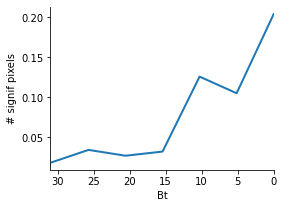

In [18]:
lstlen = []
for ibt, bt in enumerate(B_thetas[1:]) :
    itril = np.tril_indices(61)
    pvals = pval_maps_frombt36[::-1][ibt] < 0.05
    for i1, _ in enumerate(range(len(itril[0]))) :
        pvals[itril[0][i1], itril[1][i1]] = False
    # hide FPs, for plot sake, careful not to count them later on
    pvals[0:15,:] = False
    pvals[:,0:15] = False
    
    lstlen.append(len(np.where(pvals == True)[0]))
    print('Generalizing from Bt36 to Bt%.2f : \t %.3f signif pixels' % (bt*180/np.pi, len(np.where(pvals == True)[0]) /(31*31)))

fig, ax = plt.subplots(figsize = (4,3))
ax.plot(B_thetas[1:]*180/np.pi, np.asarray(lstlen)/(31*31), lw = 2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('# signif pixels')
ax.set_xlabel('Bt')
ax.set_xlim(31,0)
plt.show()